In [129]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [130]:
words = open('../data/names.txt', 'r').read().splitlines()

In [131]:
len(words)

32033

In [132]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [133]:
chars = sorted(list(set(''.join(words))))

# util

In [134]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [135]:
stoi = {s: i for i, s in itos.items()}

# Build a neural language model

## prepare data

In [136]:
block_size = 3
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        # print(''.join([itos[i] for i in context]), '--->', itos[ix])
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]        

In [137]:
X = torch.tensor(X)
Y = torch.tensor(Y)        

In [138]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## embedding matrix C

In [139]:
C = torch.randn(len(itos), 2)
C.shape

torch.Size([27, 2])

In [140]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

## hidden layer

In [141]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [142]:
h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh()
h.shape

torch.Size([228146, 100])

## final layer

In [143]:
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))

In [144]:
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [145]:
loss = F.cross_entropy(logits, Y)
loss

tensor(16.3428)

# Train a neural language model

In [190]:
C = torch.randn(len(itos), 2)
w1 = torch.randn(6, 100)
b1 = torch.randn(100)
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))
parameters = [C, w1, b1, w2, b2]

In [191]:
sum(p.nelement() for p in parameters)

3481

In [192]:
for p in parameters:
    p.requires_grad = True

In [193]:
lossi = []
for _ in tqdm(range(30000)):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))
    Xb, Yb = X[ix], Y[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # tracking
    lossi.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:09<00:00, 3259.75it/s]


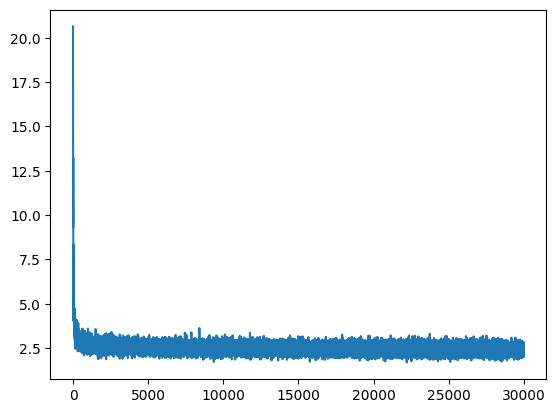

In [194]:
plt.plot(lossi)

In [195]:
lossi[-5:]

[2.478954792022705,
 2.389252185821533,
 2.0185036659240723,
 2.185878276824951,
 2.5676350593566895]

In [196]:
logits.shape

torch.Size([32, 27])

In [197]:
logits.max(1)

torch.return_types.max(
values=tensor([4.5273, 6.8336, 4.7073, 3.8796, 3.6371, 6.3527, 4.3440, 2.8592, 3.6564,
        5.1146, 3.1757, 4.3201, 4.5320, 3.9855, 4.6797, 3.6636, 5.0188, 3.2620,
        4.3508, 6.9281, 4.7764, 3.6371, 3.6371, 4.5656, 4.9164, 3.1189, 3.8833,
        3.4459, 6.6170, 3.8641, 4.7842, 4.7705], grad_fn=<MaxBackward0>),
indices=tensor([ 9,  1, 14,  0,  1,  1,  0,  1,  0,  0, 18,  1,  1,  0,  1,  0,  0, 13,
         0,  1,  0,  1,  1,  0,  0,  1,  1,  0,  9, 19, 18, 18]))

In [198]:
logits.argmax(1)[:50]

tensor([ 9,  1, 14,  0,  1,  1,  0,  1,  0,  0, 18,  1,  1,  0,  1,  0,  0, 13,
         0,  1,  0,  1,  1,  0,  0,  1,  1,  0,  9, 19, 18, 18])

In [199]:
Y[:50]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0,  3,  8,  1, 18,
        12, 15, 20, 20,  5,  0, 13,  9,  1,  0,  1, 13,  5, 12])

## mini-batch

In [ ]:
torch.randint(0, 5, (32,))

tensor([1, 2, 2, 3, 4, 1, 0, 4, 3, 1, 3, 3, 3, 3, 0, 3, 0, 2, 1, 1, 3, 2, 0, 1,
        1, 4, 4, 1, 3, 2, 4, 4])

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([111531, 110633, 165140, 224944,  19204, 187941, 216168,  56679,  11321,
         32391,  89174,  66491,   6154, 100201, 145387, 135069,   3869, 179513,
        108737, 213517,   2335, 101035,  58279, 217437, 170479, 206684,  76859,
        227681, 223407, 104329, 191740, 111718])